### Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


### Class 13 - Examples of modal superposition

[1.   Tuned mass dampers](#section_1)  
[2.   Public loading](#section_2)  
[3.   Wind buffeting response](#section_3)  
[4.   Assignment](#section_4)  

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sc

from MRPy import MRPy


## 1. Tuned mass damper <a name="section_1"></a> 

A tuned mass damper is an additional mass attached to the main system,
intended to cause a inertial reaction ressonant with some of the system
vibration modes.

The figure bellow illustrates a general model for this device:

<img src="images/TMDsingle.png" alt="Tuned mass damper" width="360px"/>

The damper must be tuned to an optimal frequency, what can be accomplished
by adjusting its mass or its stiffness. 

Let us present a very simple example, for which the original system properties 
and the tentative damper design are provided in the following script:


In [31]:
# System properties (without damper)

m0 =  1000.                      # system mass (kg)
f0 =  1.                         # natural frequency (Hz)
k0 =  m0*(2*np.pi*f0)**2         # system stiffness (N/m)
zt =  0.01                       # same damping ratio for all

# Damper design

mD =  80                         # damper mass 4% of total (kg)
mr =  mD/m0
sm =  np.sqrt(mr)

fr = (np.sqrt(1 - mr/2)/(1 + mr) + np.sqrt(1 - 2*zt*zt) - 1) \
       - (2.375 -  1.034*sm -  0.426*mr)*zt*sm \
       - (3.730 - 16.903*sm + 20.496*mr)*zt*zt*sm

fD =  1.0*fr*f0                 # Tsai and Lin (1993) - modify to fine tuning!!!
kD =  mD*(2*np.pi*fD)**2        # tuned damper stiffness (N/m)

print('Ideal damper frequency: {0:5.2f}Hz'.format(fD))


Ideal damper frequency:  0.90Hz


Damper mass may be something between 2 to 4% of effective system mass.
The higher the mass, the broader the frequency range of damper action. But a too large
damper mass is not economically feasible.

In the script above, the damper frequency, $f_{\rm D}$, can be artificially increased 
to neutralize its beneficial effect.

Now, the solution for vibration modes is:

In [32]:
# Tuned damped system matrices (by displacement method)

KD = np.array([[ k0+kD, -kD ],    # stiffness matrix
               [   -kD,  kD ]])

#mD = 1.

MD = np.array([[    m0,  0  ],    # lumped mass matrix
               [     0,  mD ]])

# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(KD, MD)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))


First vibration mode:   0.82Hz, [ 0.165  0.986]
Second vibration mode:  1.10Hz, [ 0.431 -0.902]


The aimed frequency, $f_0 = 1$Hz, has bifurcated into a slightly lower and 
a slightly higher frequencies. In first mode both masses displace in the same
direction, while in second mode they displace in opposite directions.

The modal masses, required to normalize the equilibrium equations are:


In [33]:
Mk = np.diag(np.dot(Phi.T, np.dot(MD, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))


First mode modal mass is:   105.04kg
Second mode modal mass is:  251.26kg


Now we define a harmonic excitation exactly at the original system frequency,
to be applied on the system mass (damper has no direct excitation):


In [37]:
Td =  64.                          # time discretization parameters
N  =  1024
fs =  N/Td

F0 =  0.01*k0                       # quasi-static response is 1cm
t  =  np.linspace(0, Td, N)         # time domain
s  =  np.sin(2*np.pi*fk[0]*t)         # sine wave ressonant with 1st mode

F  = [F0*s, np.zeros(s.shape)]      # loading vector

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk[k]


Finally, solving the modal equations with Duhamel, coming back from modal space, 
and visualizing results:


R.M.S. displacement of system mass:  0.103m
R.M.S. displacement of damper:       0.610m


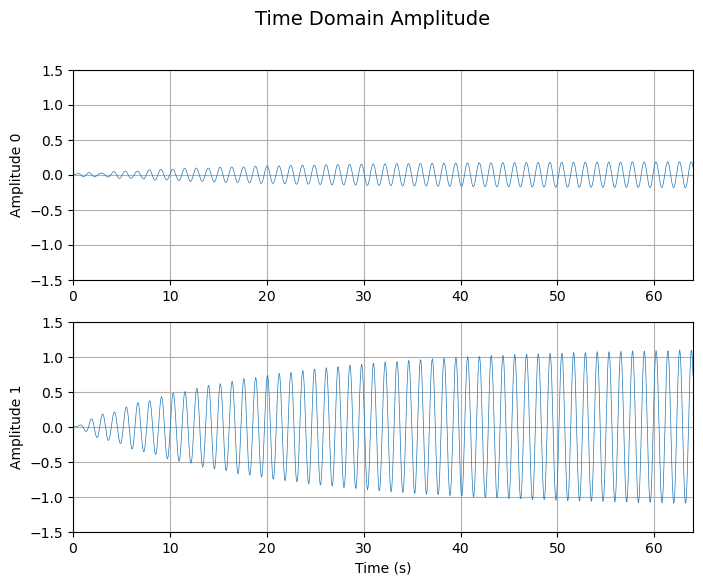

In [38]:
uk =  Fk.sdof_Duhamel(fk, zt)           # solve modal displacements by Duhamel
ut =  MRPy(np.dot(Phi, uk), fs=uk.fs)   # back from modal space to nodal displacements

ut.plot_time(1, figsize=(8,6), axis_t=[0, ut.Td, -1.5, 1.5]);

print('R.M.S. displacement of system mass: {0:6.3f}m'.format(ut[0].std()))
print('R.M.S. displacement of damper:      {0:6.3f}m'.format(ut[1].std()))


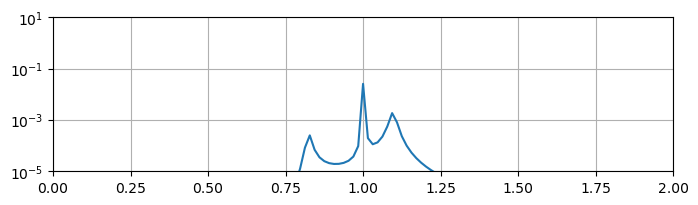

In [36]:
plt.figure(2, figsize=(8,2))
Su, fs = ut.periodogram()
plt.semilogy(ut.f_axis(), Su[0])
f2 = plt.axis([0, 2, 1e-5, 10])
plt.grid(True)


## 2. Wind buffeting <a name="section_2"></a> 

Please refer to the repository 
[Tower - Dynamic analysis of a slender tower under turbulent wind loading](http://nbviewer.jupyter.org/github/mmaiarocha/Tower/blob/master/Tower.ipynb?flush_cache=true), which presents the method behind the brazilian code _NBR6123 - 
forças devidas ao vento em edificações_, chapter 9.



## 3. Public loading <a name="section_3"></a> 


## 4. Assignments <a name="section_4"></a> 

